In [1]:
import numpy as np
from scipy import stats
import jax.numpy as jnp
from jax import grad, jit

from matplotlib import pyplot as plt

In [2]:
def sgd(loss, start, args, learning_rate=0.1, tol=1e-2, max_iter=100, seed=0):
  np.random.seed(seed)
  x = start
  nit = 0
  for _ in range(max_iter):
    nit += 1
    diff = -learning_rate * grad(loss)(x, *args)
    x += diff
    if (diff < tol).all():
      break
  return x, nit

In [3]:
def binary_search_largest(objective, min, max, tol=1e-2):
  while np.abs(min - max) > tol:
    m = (min + max) / 2
    if objective(m):
      min = m
    else:
      max = m
  return min

def binary_search_smallest(objective, min, max, tol=1e-2):
  while np.abs(min - max) > tol:
    m = (min + max) / 2
    if objective(m):
      max = m
    else:
      min = m
  return min

---

# Setup

In [4]:
DIM = 2

input distribution

In [5]:
DISTR = stats.multivariate_normal(mean=np.zeros((DIM,)))

margin

In [6]:
GAMMA = 0.1

halfspace

In [7]:
W_OPT = np.random.rand(DIM) # np.array([1, 1])
W_OPT = W_OPT / np.linalg.norm(W_OPT)
W_OPT

array([0.79372216, 0.60828047])

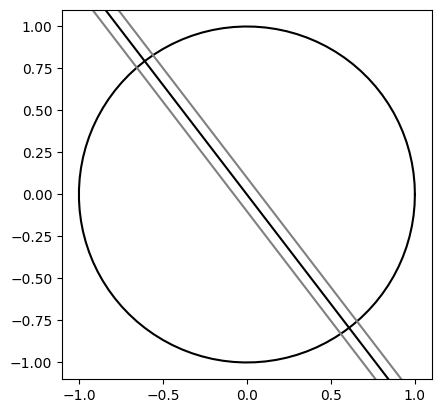

In [8]:
def plot(X=None, y=None, decision_list=None):
  _, ax = plt.subplots()
  ax.set_aspect('equal', adjustable='box')
  ax.set_xlim(-1.1, 1.1)
  ax.set_ylim(-1.1, 1.1)

  # unit cirlce
  t = np.linspace(0, np.pi * 2, 100)
  ax.plot(np.cos(t), np.sin(t), c='black')

  # opt & margin
  _x = np.linspace(-1.1, 1.1, 100)
  _y = - W_OPT[0] * _x / W_OPT[1]
  ax.plot(_x, _y + GAMMA, c='grey')
  ax.plot(_x, _y - GAMMA, c='grey')
  ax.plot(_x, _y, c='black')

  if X is not None:
    if y is None:
      ax.scatter(X[:, 0], X[:, 1], marker='x', c='black')
    else:
      ax.scatter(X[y, 0], X[y, 1], marker='+', c='red')
      ax.scatter(X[~y, 0], X[~y, 1], marker='_', c='blue')

  if decision_list is not None:
    for w, T in decision_list:
      _x = np.linspace(-1.1, 1.1, 100)
      _y = - w[0] * _x / w[1]
      ax.plot(_x, _y + T, c='lightblue')
      ax.plot(_x, _y - T, c='lightblue')
      ax.plot(_x, _y, c='blue')

  plt.show()

plot()

sample points from unit sphere while enforcing large-margin property

In [9]:
def sample_points(n, decision_list=[], return_ratio=False):
  result = []
  m = 0
  while len(result) < n:
    props = DISTR.rvs(2 * n)
    m += props.shape[0]
    result += [x for x in [props[i] for i in range(props.shape[0])] if x @ x <= 1 and np.abs(W_OPT @ x) >= GAMMA and all([np.abs(w @ x) < T for w, T in decision_list])]
    if return_ratio and len(result) == 0 and m > 100:
      return None, 0
  if return_ratio:
    return np.array(result[:n]), len(result) / m
  return np.array(result[:n])

In [10]:
X = sample_points(n=100)

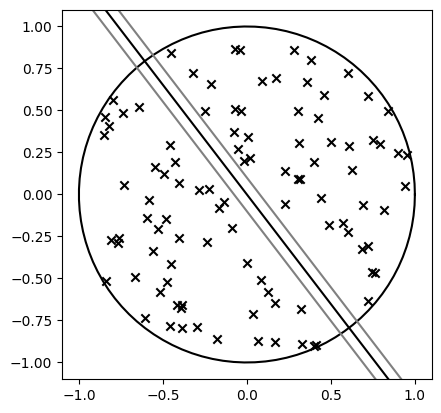

In [11]:
plot(X)

noise model, may be adapted based on experiment

In [12]:
def get_noise(X, eta, eta_til):
  return np.random.uniform(eta_til, eta, size=X.shape[0])

In [13]:
noise = get_noise(X, eta_til=0, eta=0.2)

obtaining noisy samples

In [14]:
def classify_points(X, noise=None):
  n = X.shape[0]

  y = X @ W_OPT >= 0

  if noise is not None:
    for i in range(n):
      u = np.random.uniform(0, 1)
      if u <= noise[i]:
        y[i] = ~y[i]

  return y

In [15]:
y = classify_points(X, noise)

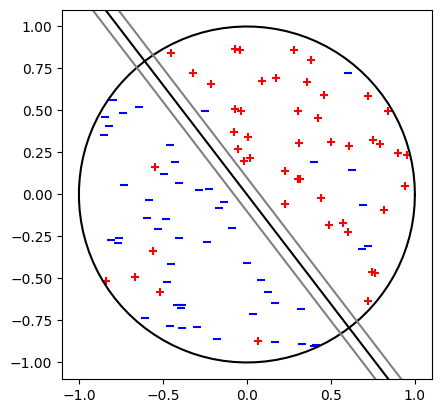

In [16]:
plot(X, y)

implementation of the algorithm

In [17]:
def leaky_relu(x, lam):
  if x >= 0:
    return (1 - lam) * x
  else:
    return lam * x

In [19]:
def alg(m, eta_til, eta, eps, find_smaller_Ts=False, verbose=False, tol=1e-3, seed = 6):
  np.random.seed(seed)

  lam = eta + eps
  decision_list = []
  while sample_points(n=m, decision_list=decision_list, return_ratio=True)[1] >= eps:
    def w_loss(w):
      X = sample_points(n=m, decision_list=decision_list)
      noise = get_noise(X, eta_til=eta_til, eta=eta)
      y = classify_points(X, noise).astype(int) * 2 - 1
      return jnp.mean(jnp.array([leaky_relu(z, lam) for z in -y * (X @ w)]))
    w, nit = sgd(w_loss, start=np.zeros((DIM,)), args=(), tol=tol, seed=seed)
    if verbose:
      print('number of iterations to find w', nit)
    w = w / np.linalg.norm(w)

    X = sample_points(n=m, decision_list=decision_list)
    noise = get_noise(X, eta_til=eta_til, eta=eta)
    y = classify_points(X, noise)

    def estimate_error(T=0):
      sample_mask = jnp.abs(X @ w) >= T
      return jnp.logical_xor(X @ w >= 0, y)[sample_mask].mean()
    def estimate_mass(T):
      return (jnp.abs(X @ w) >= T).mean()

    if verbose:
      print('finding T_max...')
    # find largest threshold such that enough points are classified
    T_max = binary_search_largest(lambda T: estimate_mass(T) >= GAMMA * eps, min=0, max=1, tol=tol)
    if verbose:
      print('fraction of points classified by T_max', estimate_mass(T_max), '; T_max', T_max)
        
    if find_smaller_Ts is False:
      # choose T to minimize misclassification error (done in paper)
      Ts = np.linspace(0.0, T_max, m)
      errors = np.array([estimate_error(T) for T in Ts])
      T = Ts[np.argmin(errors)]
      if verbose:
        print('fraction of points classified by T', estimate_mass(T), 'misclassification error', estimate_error(T), '; T', T)
    else:
      # choose T to be as small as possible while having suff. small misclassification error
      if verbose:
        print('finding T_min...')
      T_min = binary_search_smallest(lambda T: estimate_error(T) <= eta, min=0, max=T_max, tol=tol)
      if verbose:
        print('fraction of points classified by T_min', estimate_mass(T_min), 'misclassification error', estimate_error(T_min), '; T_min', T_min)
      T = T_min

    decision_list.append((w, T))
  if verbose:
    print('end condition', sample_points(n=m, decision_list=decision_list, return_ratio=True)[1])

  return decision_list

In [21]:
decision_list = alg(m=100, eta_til=0.4, eta=0.4, eps=0.1, find_smaller_Ts=False, verbose=True, seed=0)
decision_list, W_OPT

number of iterations to find w 13
finding T_max...
fraction of points classified by T_max 0.01 ; T_max 0.98046875
fraction of points classified by T 0.07 misclassification error 0.2857143 ; T 0.8517203282828283
number of iterations to find w 4
finding T_max...
fraction of points classified by T_max 0.01 ; T_max 0.908203125
fraction of points classified by T 0.01 misclassification error 0.0 ; T 0.8990293560606061
number of iterations to find w 4
finding T_max...
fraction of points classified by T_max 0.01 ; T_max 0.8916015625
fraction of points classified by T 0.37 misclassification error 0.35135135 ; T 0.5223524305555555
number of iterations to find w 22
finding T_max...
fraction of points classified by T_max 0.01 ; T_max 0.638671875
fraction of points classified by T 0.69 misclassification error 0.28985506 ; T 0.22579308712121213
end condition 0.07928571428571428


([(Array([0.63774955, 0.77024376], dtype=float32), 0.8517203282828283),
  (Array([0.7397124 , 0.67292315], dtype=float32), 0.8990293560606061),
  (Array([0.7397124 , 0.67292315], dtype=float32), 0.5223524305555555),
  (Array([0.896987 , 0.4420569], dtype=float32), 0.22579308712121213)],
 array([0.79372216, 0.60828047]))

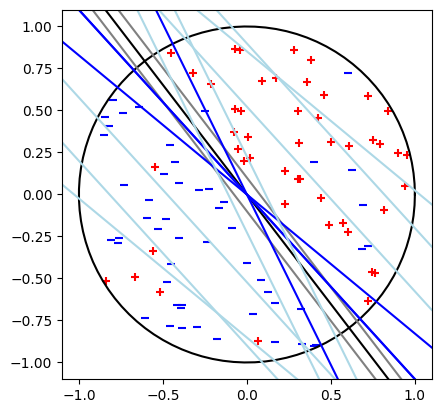

In [22]:
plot(X, y, decision_list=decision_list)

---

using a decision list for predicting class labels

In [23]:
def predict(X, decision_list):
  n = X.shape[0]
  y_pred = np.random.choice([False, True], p=[0.5, 0.5], size=n)
  predicted = np.zeros(shape=(n,), dtype=bool)

  for w, T in decision_list:
    sample_mask = ~predicted & (np.abs(X @ w) >= T)
    y_pred[sample_mask] = (X @ w >= 0)[sample_mask]
    predicted[sample_mask] = True

  return y_pred, predicted

In [26]:
y_pred, fraction_predicted = predict(X, decision_list)
y_pred, fraction_predicted.mean()

(array([False, False,  True,  True,  True,  True, False, False, False,
         True,  True, False, False,  True, False, False,  True,  True,
        False, False,  True, False, False, False, False, False,  True,
        False, False, False,  True, False, False,  True,  True, False,
         True,  True,  True, False, False,  True,  True,  True, False,
        False,  True, False,  True,  True,  True, False, False,  True,
         True,  True, False,  True,  True, False, False, False,  True,
         True,  True, False,  True,  True,  True, False, False, False,
         True, False,  True, False,  True, False,  True,  True, False,
        False,  True,  True, False,  True, False,  True, False,  True,
        False,  True, False, False,  True,  True, False, False, False,
        False]),
 0.76)

empirically estimating the error

In [24]:
def estimate_error(y, y_pred):
  return np.logical_xor(y_pred, y).mean()

In [28]:
estimate_error(y, y_pred)

0.28